In [1]:
import s3fs
import boto3
import time

from PIL import Image
import numpy as np
import hashlib
import io
import json
import gc
from tqdm import tqdm

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [2]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
# device = 'cpu'


Using device: cuda



In [3]:
def data_loading(path):
    with open(path, 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42,stratify=y)
    return train_x, test_x, train_y, test_y

In [4]:
train_x, test_x, train_y, test_y = data_loading('TESTDATA.json')
len(train_x)

2706

In [5]:
def data_loading_COMPCAR():
    train_x, test_x, train_y, test_y = data_loading('TESTDATA.json')

    with open('COMPCAR.json', 'r') as file:
        test_data = json.load(file)
    x = list(test_data.keys())
    y = list(test_data.values())
    train_x_2, test_x_2, train_y_2, test_y_2 = train_test_split(x, y, test_size=0.90, random_state=42,stratify=y)

    train_x.extend(train_x_2)
    train_y.extend(train_y_2)
    
    test_x.extend(test_x_2[:1500])
    test_y.extend(test_y_2[:1500])
    return train_x, test_x, train_y, test_y

In [6]:
train_x, test_x, train_y, test_y = data_loading_COMPCAR()

In [7]:
def preprocess_image(image_bytes):
    # Open the image as bytes
    image = Image.open(io.BytesIO(image_bytes))

    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(model, image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(256, 256)):
    models = ['ResNet','VGG16', 'SVM', 'YOLO']
    if model in models:
        preprocess = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),])

    image_tensors = []
    for i in tqdm(range(0, len(image_paths), batch_size), total=len(image_paths)//batch_size, desc='Processing Images'):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes)
                batch_image_tensors.append(image_tensor)
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [8]:
def run_ResNet(im):
    labels = []
    # Step 1: Initialize model with the best available weights
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights).to(device)
    model.eval()

    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()
    image_tensors = im
    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(image_tensors)
    batch = batch.to(device)
    start_time = time.time()

    with torch.no_grad():
        predictions = model(batch).softmax(1)
        predictions = predictions.to(device)
        top_probs, top_indices = torch.topk(predictions, k=7, dim=1)

        for i in range(len(image_tensors)):
            #print(f"Predictions for image {i + 1}:")
            image_labels = [] 
            for j in range(7):  # Top 3 predictions
                class_id = top_indices[i][j].item()
                score = top_probs[i][j].item()
                category_name = weights.meta["categories"][class_id]
                if score > 0.01:
                    image_labels.append(category_name)
                else:
                    category_name = ''
                    image_labels.append(category_name)

                #print(f"{j + 1}. {category_name}: {100 * score:.1f}%")

            labels.append(image_labels)
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return labels

In [9]:
def get_result(labels):
    exterior = ['ambulance','car wheel','racer','golfcart','mobile home','beach wagon', 
                'convertible','garbage truck','jeep', 'limousine', 'mini bus','minibus',
                'minivan','mini van','moving van', 'passenger car','recreational vehicle', 'school bus', 
                'sports car','trailor truck','trolley bus', 'cab', 'freight car', 'police van', 'grille', 'pickup']

    result_resnet = [1 if (sublist[0] in exterior or sublist[1] in exterior or sublist[2] in exterior)
                  else 0 for sublist in labels]

    result_resnet = [0 if ('seat belt' in sublist or 'sliding door' in sublist or 'stretcher' in sublist
                        or 'odometer' in sublist or 'radio' in sublist or 'cassette player' in sublist
                        or 'loudspeaker' in sublist or 'barber chair' in sublist or 'electric fan' in sublist
                        or 'desk' in sublist or 'microwave' in sublist or 'home theater' in sublist
                        or 'dining table' in sublist or 'folding chair' in sublist or 'studio couch' in sublist
                        or 'neck brace' in sublist) else val for sublist, val in zip(labels, result_resnet)]
    return result_resnet

In [10]:
def show_matrix(test_y,result,filename=None):
    print(classification_report(test_y, result))
    cm = confusion_matrix(test_y, result)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interior','exterior'])
    disp.plot()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [12]:
train_x, test_x, train_y, test_y = data_loading_COMPCAR()
gc.collect()
im = process_duplicates_image_ids('ResNet',image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
                boto_s3=boto3_s3,
                s3fs_=s3fs_)

Processing Images:   0%|          | 0/26 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 27it [04:21,  9.68s/it]                        

Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32


In [21]:
def main_Resnet50():
    label = run_ResNet(im)
    result = get_result(label)
    show_matrix(test_y,result,filename='ResNet50_results.png')
    return result

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Time taken for testing: 61.59763050079346 seconds
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1477
           1       0.96      0.95      0.96      1184

    accuracy                           0.96      2661
   macro avg       0.96      0.96      0.96      2661
weighted avg       0.96      0.96      0.96      2661



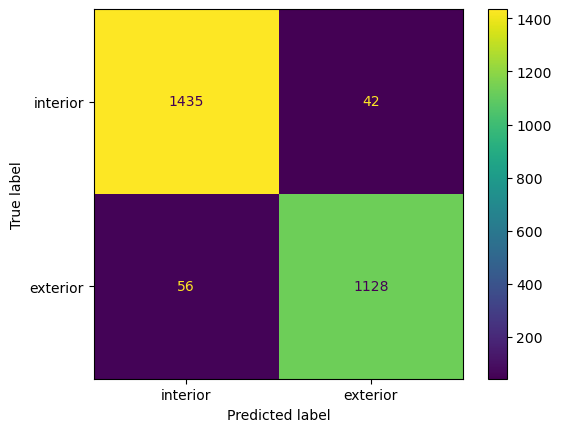

In [22]:
result = main_Resnet50()

In [25]:
misclassified_indices = []
for i in range(len(test_y)):
    if test_y[i] != result[i]:
        misclassified_indices.append(i)
        
misclassified_indices



[123,
 125,
 126,
 132,
 139,
 158,
 188,
 233,
 242,
 262,
 281,
 297,
 301,
 322,
 342,
 344,
 396,
 412,
 440,
 446,
 460,
 473,
 474,
 566,
 577,
 606,
 620,
 622,
 638,
 706,
 708,
 717,
 736,
 744,
 752,
 780,
 782,
 846,
 860,
 878,
 881,
 887,
 891,
 961,
 963,
 1007,
 1013,
 1027,
 1028,
 1090,
 1097,
 1104,
 1113,
 1143,
 1224,
 1314,
 1329,
 1380,
 1388,
 1425,
 1429,
 1437,
 1458,
 1467,
 1473,
 1510,
 1537,
 1555,
 1565,
 1623,
 1655,
 1778,
 1793,
 1807,
 1862,
 1887,
 1895,
 1950,
 1956,
 1971,
 1972,
 2090,
 2092,
 2108,
 2244,
 2261,
 2392,
 2419,
 2421,
 2437,
 2465,
 2519,
 2541,
 2542,
 2594,
 2629,
 2646,
 2651]

# ResNet50 last layers trained


In [11]:
class CustomDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        target_tensor = torch.tensor([target], dtype=torch.float32)

        return image, target_tensor

def dataloader(im,train_y,im_test,test_y):
    train_images, val_images, train_targets, val_targets = train_test_split(im, train_y, test_size=0.3, random_state=42,stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets)
    val_dataset = CustomDataset(val_images, val_targets)
    
    test_dataset = CustomDataset(im_test, test_y)

    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
    
    return train_loader,val_loader,test_loader

In [12]:
def train_trainedResNet(epochs,train_loader,val_loader):
    start_time = time.time()

    model = resnet50(pretrained=True).to(device)


    for param in model.parameters():
        param.requires_grad = False   

    model.fc = nn.Sequential(
        nn.Linear(2048, 1, bias=True),
        nn.Sigmoid() 
    ).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.fc.parameters())


    num_epochs = epochs
    train_loss = []
    validation_loss = []
    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets).to(device)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, targets).to(device)

        train_loss.append(loss.item())
        validation_loss.append(val_loss.item())
        combined_loss = loss.item() + val_loss.item()
        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
            best_model_state = model.state_dict()
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')
    plt.plot([x for x in range(num_epochs)],train_loss, label='Training set')
    plt.plot([x for x in range(num_epochs)],validation_loss,label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and validation error ResNet50')
    plt.legend()
    plt.savefig('training_validation_figure.png')
    plt.show()
    torch.save(model.state_dict(), 'model_resnet50.pth')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return best_model_state,model

In [13]:
def test_ResNet(best_model_state,model,test_loader):
    start_time = time.time()

    model.load_state_dict(best_model_state)
    model.eval()

    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs)

    predictions = torch.cat(predictions, dim=0).to(device)
    threshold = 0.5
    predicted_labels = (predictions > threshold).float()

    predicted_labels = predicted_labels.int()

    result = predicted_labels.squeeze().tolist()
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return result

In [14]:
def show_matrix(test_y,result,filename=None):
    print(classification_report(test_y, result))
    cm = confusion_matrix(test_y, result)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['interior','exterior'])
    disp.plot()
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [16]:
def main_trainedResNet_compcar():
    train_x, test_x, train_y, test_y = data_loading_COMPCAR()
    gc.collect()
    im = process_duplicates_image_ids('ResNet',image_paths=train_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    im_test = process_duplicates_image_ids('ResNet',image_paths=test_x,batch_size=100,bucket="s3-path",
            boto_s3=boto3_s3,
            s3fs_=s3fs_)
    train_loader,val_loader,test_loader = dataloader(im,train_y,im_test,test_y)
    best_model,model = train_trainedResNet(30,train_loader,val_loader)
    result = test_ResNet(best_model,model,test_loader)
    show_matrix(test_y,result,filename='trainedResNet_results_comp.png')
    return result

Processing Images:   0%|          | 0/53 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 54it [07:00,  7.79s/it]                        


Tensor Shape: torch.Size([5324, 3, 256, 256])
Tensor Dtype: torch.float32


Processing Images: 27it [03:30,  7.80s/it]                        


Tensor Shape: torch.Size([2661, 3, 256, 256])
Tensor Dtype: torch.float32


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.1846795678138733, Val Loss: 0.07169977575540543
Epoch 2/30, Train Loss: 0.04565979540348053, Val Loss: 0.04964971914887428
Epoch 3/30, Train Loss: 0.024049175903201103, Val Loss: 0.05006101354956627
Epoch 4/30, Train Loss: 0.11061680316925049, Val Loss: 0.03141852468252182
Epoch 5/30, Train Loss: 0.013391198590397835, Val Loss: 0.030944325029850006
Epoch 6/30, Train Loss: 0.19016043841838837, Val Loss: 0.02890046499669552
Epoch 7/30, Train Loss: 0.19840186834335327, Val Loss: 0.027041388675570488
Epoch 8/30, Train Loss: 0.33400532603263855, Val Loss: 0.04599418863654137
Epoch 9/30, Train Loss: 0.004803705494850874, Val Loss: 0.058437615633010864
Epoch 10/30, Train Loss: 0.2091410607099533, Val Loss: 0.03789538890123367
Epoch 11/30, Train Loss: 0.00634453259408474, Val Loss: 0.043493423610925674
Epoch 12/30, Train Loss: 0.08324601501226425, Val Loss: 0.052865345031023026
Epoch 13/30, Train Loss: 0.009248701855540276, Val Loss: 0.03949989378452301
Epoch 14/30, T

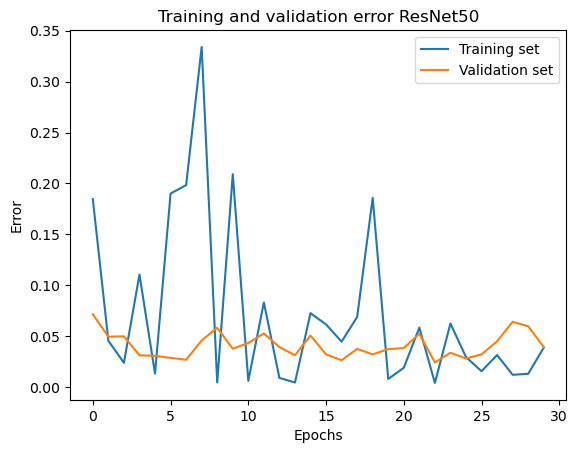

Time taken for training: 552.5842175483704 seconds
Time taken for testing: 8.807081699371338 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1477
           1       0.99      0.97      0.98      1184

    accuracy                           0.98      2661
   macro avg       0.98      0.98      0.98      2661
weighted avg       0.98      0.98      0.98      2661



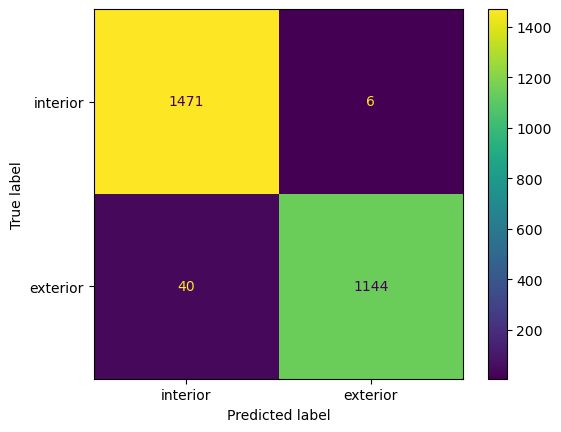

In [19]:
result = main_trainedResNet_compcar()

In [39]:
misclassified_indices = []
for i in range(len(test_y)):
    if test_y[i] != result[i]:
        misclassified_indices.append(i)
        
misclassified_indices


[149,
 188,
 206,
 213,
 221,
 281,
 301,
 306,
 322,
 326,
 327,
 382,
 412,
 440,
 446,
 474,
 491,
 547,
 591,
 620,
 622,
 678,
 712,
 736,
 747,
 759,
 806,
 878,
 887,
 963,
 981,
 1004,
 1097,
 1143,
 1388,
 1510,
 1626,
 1770,
 1793,
 1846,
 2034,
 2184,
 2211,
 2261]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# DEFINE INTERIOR/EXTERIOR

In [ ]:
# s3.ls('s3-path')

In [ ]:
# import ast
# s3 = boto3.client('s3')

# # Specify the name of your S3 bucket and the key (path) of the text file within the bucket
# bucket_name = "s3-path"
# key = ""

# # Download the text file from S3
# s3_object = s3.get_object(Bucket=bucket_name, Key=key)
# text_data = s3_object['Body'].read().decode('utf-8')

# # Parse the text data into a Python dictionary using ast.literal_eval
# label_dict = ast.literal_eval(text_data)

# # Print the dictionary
# print(label_dict)

In [ ]:
# split_values = [word for value in  label_dict.values() for word in value.split(", ")]

In [ ]:
# split_values

# WORDVECTOR

In [ ]:
pip install gensim

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [ ]:
wv.most_similar("van")

In [ ]:
# from gensim.models import Word2Vec
# import random
# # Assuming 'tokenized_sentences' is a list of tokenized sentences or word sequences from your text data

# # Train Word2Vec model
# word2vec_model = Word2Vec(sentences=[sentence.split() for sentence in split_values], vector_size=1000, window=5, min_count=1, workers=4)

# # Use the trained Word2Vec model\
# # Assuming 'word2vec_model' is your trained Word2Vec model
# random_word = random.choice(word2vec_model.wv.index_to_key)

# # Print the random word
# closest_label, similarity = word2vec_model.wv.most_similar("truck", topn=10)[0]

# # Print the closest label and its similarity score
# print("Closest label:", closest_label)
# print("Similarity:", similarity)

# LDA TOPIC MODELLING (NEEDS SENTENCES)

In [ ]:
# import gensim
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(split_values)
# # Create Corpus
# texts = split_values
# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]
# # View
# print(corpus[:1][0][:30])

# LABELS


In [ ]:
# import ast
# s3 = boto3.client('s3')

# # Specify the name of your S3 bucket and the key (path) of the text file within the bucket
# bucket_name = "dpgos-osdata-boaz-beukers-sandbox"
# key = "labels/clustered_imagenet_labels.json"

# # Download the text file from S3
# s3_object = s3.get_object(Bucket=bucket_name, Key=key)
# text_data = s3_object['Body'].read().decode('utf-8')

# # Parse the text data into a Python dictionary using ast.literal_eval
# label_dict_clust = ast.literal_eval(text_data)

# # Print the dictionary
# #print(label_dict_clust)
# label_dict_clust = set(label_dict_clust.values())
# print(label_dict_clust)

In [ ]:
# import ast
# s3 = boto3.client('s3')

# # Specify the name of your S3 bucket and the key (path) of the text file within the bucket
# bucket_name = "s3-path"
# key = "."

# # Download the text file from S3
# s3_object = s3.get_object(Bucket=bucket_name, Key=key)
# text_data = s3_object['Body'].read().decode('utf-8')

# # Parse the text data into a Python dictionary using ast.literal_eval
# label_dict = ast.literal_eval(text_data)

# # Print the dictionary
# label_values = [value[1] for value in label_dict.values()]

# # Create a set from the values
# label_set = set(label_values)

# # Print the set
# print(list(label_set))

In [ ]:
# imagenet_classes = label_dict

# class_wnid2new_label = label_dict_clust

# new_labels = sorted(set(class_wnid2new_label.values()))
# new_label2index = {}
# for i, classname in enumerate(new_labels):
#     new_label2index[classname] = i


# def replace_labels(labels):
#     ret = torch.LongTensor(len(labels))

#     for i, label in enumerate(labels):
#         class_idx = str(label.item())
#         class_wnid, _ = imagenet_classes[class_idx]
#         new_labelname = class_wnid2new_label[class_wnid]
#         new_label = torch.tensor(new_label2index[new_labelname])
#         ret[i] = new_label
#     return ret

In [ ]:
# label_set

In [ ]:
# label_set - label_dict_clust

In [ ]:
exterior = ['ambulance','beach_wagon', 'convertible','garbage_truck','jeep', 'limousine', 'minibus', 'minivan','moving_van',
            'passenger_car','recreational_vehicle', 'school_bus', 'sports_car','trailor_truck','trolley_bus', 'cab', 'freight_car']
